In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

This is my attempt of checking how the energy spectrum of geoneutrinos (expected number of geonu detection per energy bin) is affected by varying the oscillation parameters. This is based on formula 4.1 from Ingrida's thesis:

$$\frac{dN(\overrightarrow{r}, E)}{dE} = \epsilon \frac{\lambda N_A}{\mu} \sigma_{\nu}(\frac{dn_{\nu}}{dE})_i \int P_{ee}(E, |\overrightarrow{r}-\overrightarrow{r'}|)\frac{A(\overrightarrow{r'}) \rho(\overrightarrow{r'})}{4 \pi |\overrightarrow{r}-\overrightarrow{r'}|^2} d\overrightarrow{r'}$$

All the terms in this equation are described in Table 4.1 (page 49 in Ingrida's thesis). The point of this notebook is to develop a skeleton method for computing the volume integral as a function of energy, $\Delta m_{21}^2$ and $\theta_{12}$. Because we're talking about SNO+ (obviously), $\overrightarrow{r}$ is the position of the SNO+ detector. This is the outline of what I'm trying to do:

$\;\;\;\;\;\;$1) Create an array that contains a grid of points that correspond to the relevant points inside the Earth (points in crust and mantle, core contains negligible amounts of Uranium and Thorium); maybe have two arrays, one with Cartesian coordinates, one with polar coordinates, and the same index in the two arrays point to the coordinates of the same point $\overrightarrow{r'}$.


$\;\;\;\;\;\;$2) Split the points in the array into different regions $R_1, R_2, ...$ such that each region will have a characteristic $A_{Th}, A_U$ (Thorium and Uranium mass percentage abundances) and $\rho$ - we can make separate arrays for these as well, and again, the index will identify properties of the same point


$\;\;\;\;\;\;$3) Create a function that outputs an array P_ee (where again, the index identifies the value) for a certain energy, $\Delta m_{21}^2$ and $\theta_{12}$. This will take as inputs an array of energy values (the middle points of the bins we will use to plot the expected detected counts), and one value for each of the oscillation parameters

I will deal with the other stuff in the equation above later; I think the only things dependent on energy are $\sigma_{\nu}$ (which should be denoted $\sigma_{IBD}$ in my opinion - the inverse beta decay cross section i.e. encoding how likely a geoneutrino is to actually interact in the detector material, and the $\frac{dn_{\nu}}{dE}$ term, which I think is about the energy spectrum of geoneutrinos that come out of the decay chains of Uranium and Thorium -- I think Shuai is looking into this.

But for now, we do the volume integral. In the future, these will all be nice functions -- we'll have one function that makes a grid of whatever size is wanted (depending on wanted precision), different functions corresponding to different geological models that split the points into regions and contain information about densities and abundances, all that. But now we just write things dirrectly for a very simple model with not many grid points (because my computer is slow): Have two relevant sections: mantle and core. Assume abundances in core are $0$, and density and abundances for the mantle are uniform. 

Then I'll pick one value for $\Delta m_{21}^2$ and $\theta_{12}$ (the standard ones), and an energy array. The final result will be an array of size equal to the size of the energy array, each containing the value of the integral corresponding to the energy. We can plot this, then can use some other values of $\Delta m_{21}^2$ and $\theta_{12}$ and plot those as well, see how things change. 

Ok, let's go!!


***Adding more geological models: next step would be to separate mantle and crust, then maybe separate them into shells even further, then use the polar coordinates to distinguish between continental and oceanic crust. A last step would be to make area around the detector include a more detailed model, but I'm not sure how many of these models and levels of detail would actually be required to probe geonu ascillation effects on the spectrum. We'll see

The next two cells are an attempt to make the earth grid but it's very inefficient; skip to uncommented cell, which is supposed to do the same thing using meshgrid

In [10]:
#Make grid of coordinates in 3D; Earth assumed spherical, number of points in each direction should be equal and can be adjusted
'''
x_coordinates = np.linspace(-6371, 6371, 20)
y_coordinates = np.linspace(-6371, 6371, 20)
z_coordinates = np.linspace(-6371, 6371, 20)'''

'\nx_coordinates = np.linspace(-6371, 6371, 20)\ny_coordinates = np.linspace(-6371, 6371, 20)\nz_coordinates = np.linspace(-6371, 6371, 20)'

In [11]:
#Make array of Earth points; I'm bad at coding so this might be an inefficient way to do this, please bear with me
'''
earth_grid_0 = np.array([])
counter = 1

for i in range(len(x_coordinates)):
    for j in range(len(y_coordinates)):
        for k in range(len(z_coordinates)):
            if x_coordinates[i]**2 + y_coordinates[j]**2 + z_coordinates[k]**2 <= 6371**2:
                earth_grid_0 = np.append(earth_grid_0, [np.array([x_coordinates[i], y_coordinates[j], z_coordinates[k]])])
                print("The " + str(counter) + "th point has been appended")
                counter += 1
                
                
# Reshape the array to have three columns; now it's literally a list of points, each with (x, y, z) coordinates
# maybe more efficient to do polar conversion first but let's keep this for now
earth_grid_0 = earth_grid_0.reshape(-1, 3)

print(earth_grid_0)'''

'\nearth_grid_0 = np.array([])\ncounter = 1\n\nfor i in range(len(x_coordinates)):\n    for j in range(len(y_coordinates)):\n        for k in range(len(z_coordinates)):\n            if x_coordinates[i]**2 + y_coordinates[j]**2 + z_coordinates[k]**2 <= 6371**2:\n                earth_grid_0 = np.append(earth_grid_0, [np.array([x_coordinates[i], y_coordinates[j], z_coordinates[k]])])\n                print("The " + str(counter) + "th point has been appended")\n                counter += 1\n                \n                \n# Reshape the array to have three columns; now it\'s literally a list of points, each with (x, y, z) coordinates\n# maybe more efficient to do polar conversion first but let\'s keep this for now\nearth_grid_0 = earth_grid_0.reshape(-1, 3)\n\nprint(earth_grid_0)'

My current laptop doesn't have a lot of memory so I can't have a big grid, grid_count should definitely be much higher for an accurate result; for this count, I can't even implement any model that separates the mantle and the crust because the mantle is so thin; 

In [12]:
#using meshgrid


grid_count = 50
coordinates = np.linspace(-6371, 6371, grid_count)
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

earth_grid = np.zeros((grid_count**3, 3))
index = 0

for i in range(grid_count):
    for j in range(grid_count):
        for k in range(grid_count):
            if x_coordinates[i, j, k]**2 + y_coordinates[i, j, k]**2 + z_coordinates[i, j, k]**2 <= 6371**2:
                earth_grid[index] = np.array([x_coordinates[i, j, k], y_coordinates[i, j, k], z_coordinates[i, j, k]])
                index += 1

earth_grid = earth_grid[:index]


Now we have a sphere split into equally distanced points, centered at $(0, 0, 0)$, with a radius equal to Earth's radius. The next two cells are not necessary -- the plotting one is kinda dumb actually and it takes ages to compute if you pick a grid with small distances between the points. PLEASE DON"T RUN THE NEXT 2 CELLS, THANK YOU!

In [13]:
print(earth_grid)

[[-1690.26530612 -6110.95918367  -390.06122449]
 [-1690.26530612 -6110.95918367  -130.02040816]
 [-1690.26530612 -6110.95918367   130.02040816]
 ...
 [ 1690.26530612  6110.95918367  -130.02040816]
 [ 1690.26530612  6110.95918367   130.02040816]
 [ 1690.26530612  6110.95918367   390.06122449]]


In [14]:
# 3D scatter plot of whole Earth grid
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in earth_grid:
    x, y, z = point
    ax.scatter(x, y, z, c='r', marker='.', s = 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set limits for each axis
ax.set_xlim([-6371, 6371])  # Set x-axis limits
ax.set_ylim([-6371, 6371])  # Set y-axis limits
ax.set_zlim([-6371, 6371])  # Set z-axis limits

plt.show()'''

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\nfor point in earth_grid:\n    x, y, z = point\n    ax.scatter(x, y, z, c='r', marker='.', s = 1)\n\nax.set_xlabel('X')\nax.set_ylabel('Y')\nax.set_zlabel('Z')\n\n# Set limits for each axis\nax.set_xlim([-6371, 6371])  # Set x-axis limits\nax.set_ylim([-6371, 6371])  # Set y-axis limits\nax.set_zlim([-6371, 6371])  # Set z-axis limits\n\nplt.show()"

The 2 next cells split the earth points into two sets of points: points in the mantle (+crust, but crust is thin so just use mantle in this first approximation) and core.

In [22]:
'''
core_radius = 3486
mantle_crust_grid_0 = np.array([])
core_grid_0 = np.array([])'''

'\ncore_radius = 3486\nmantle_crust_grid_0 = np.array([])\ncore_grid_0 = np.array([])'

I use append in the cell above but that's very inefficient. Rewritten in a better way below.

In [23]:
'''
for point in earth_grid:
    if point[0]**2 + point[1]**2 + point[2]**2 >= core_radius**2:
        mantle_crust_grid_0 = np.append(mantle_crust_grid_0, point)
    else:
        core_grid = np.append(core_grid, point)        
# Reshape the array to have three columns
mantle_crust_grid_0 = mantle_crust_grid_0.reshape(-1, 3)
core_grid_0 = core_grid_0.reshape(-1, 3)

print(mantle_crust_grid_0)'''

'\nfor point in earth_grid:\n    if point[0]**2 + point[1]**2 + point[2]**2 >= core_radius**2:\n        mantle_crust_grid_0 = np.append(mantle_crust_grid_0, point)\n    else:\n        core_grid = np.append(core_grid, point)        \n# Reshape the array to have three columns\nmantle_crust_grid_0 = mantle_crust_grid_0.reshape(-1, 3)\ncore_grid_0 = core_grid_0.reshape(-1, 3)\n\nprint(mantle_crust_grid_0)'

In [24]:
mantle_crust_mask = (earth_grid[:, 0]**2 + earth_grid[:, 1]**2 + earth_grid[:, 2]**2 >= core_radius**2)

mantle_crust_grid = earth_grid[mantle_crust_mask]
core_grid = earth_grid[~mantle_crust_mask]

# Reshape the arrays to have three columns
mantle_crust_grid = mantle_crust_grid.reshape(-1, 3)
core_grid = core_grid.reshape(-1, 3)

print(mantle_crust_grid)

[[-1690.26530612 -6110.95918367  -390.06122449]
 [-1690.26530612 -6110.95918367  -130.02040816]
 [-1690.26530612 -6110.95918367   130.02040816]
 ...
 [ 1690.26530612  6110.95918367  -130.02040816]
 [ 1690.26530612  6110.95918367   130.02040816]
 [ 1690.26530612  6110.95918367   390.06122449]]


Again, I am begging you, do not plot the next thing. If you really want to plot, set the number of points in the second code cell to something small like 20.

In [25]:
# 3D scatter plot: red core, blue mantle
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in mantle_crust_grid:
    x, y, z = point
    ax.scatter(x, y, z, c='b', marker='.', s=1)
    
for point in core_grid:
    x, y, z = point
    ax.scatter(x, y, z, c='r', marker='.', s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set limits for each axis
ax.set_xlim([-6371, 6371])
ax.set_ylim([-6371, 6371])
ax.set_zlim([-6371, 6371])

plt.show()'''

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\nfor point in mantle_crust_grid:\n    x, y, z = point\n    ax.scatter(x, y, z, c='b', marker='.', s=1)\n    \nfor point in core_grid:\n    x, y, z = point\n    ax.scatter(x, y, z, c='r', marker='.', s=1)\n\nax.set_xlabel('X')\nax.set_ylabel('Y')\nax.set_zlabel('Z')\n\n# Set limits for each axis\nax.set_xlim([-6371, 6371])\nax.set_ylim([-6371, 6371])\nax.set_zlim([-6371, 6371])\n\nplt.show()"

Now set the relevant geological parameter for mantle and for core; The U and Th abundances will be 0 in the core so the density won't matter - just set it to 0 for simplicity as well. These will be nicely organized when I use a more complicated model. Also, given that this first iteration is an extremely rough approximation, we won't take into account uncertainties on the abundances or anything like that. Maybe these can be included in the future.

In [26]:
rho_core = 0
A_Th_core = 0
A_U_core = 0

rho_mantle = 4.5 #g/cm^3 -- I just looked this up
#I'm not sure what the units are supposed to be but this will just be a scaling factor, we mostly care about the shape of 
#the spectrum, not the absolute value 

Ideally, I want to use the information in these pics above (table from Ingrida's thesis, colorful pic with layers from docDB 5512 also by Ingrida) to calculate $A_{Th}$ and $A_U$ as some weighted average of the values in each sub layer. For now, we do a very hand-wavy calculation:

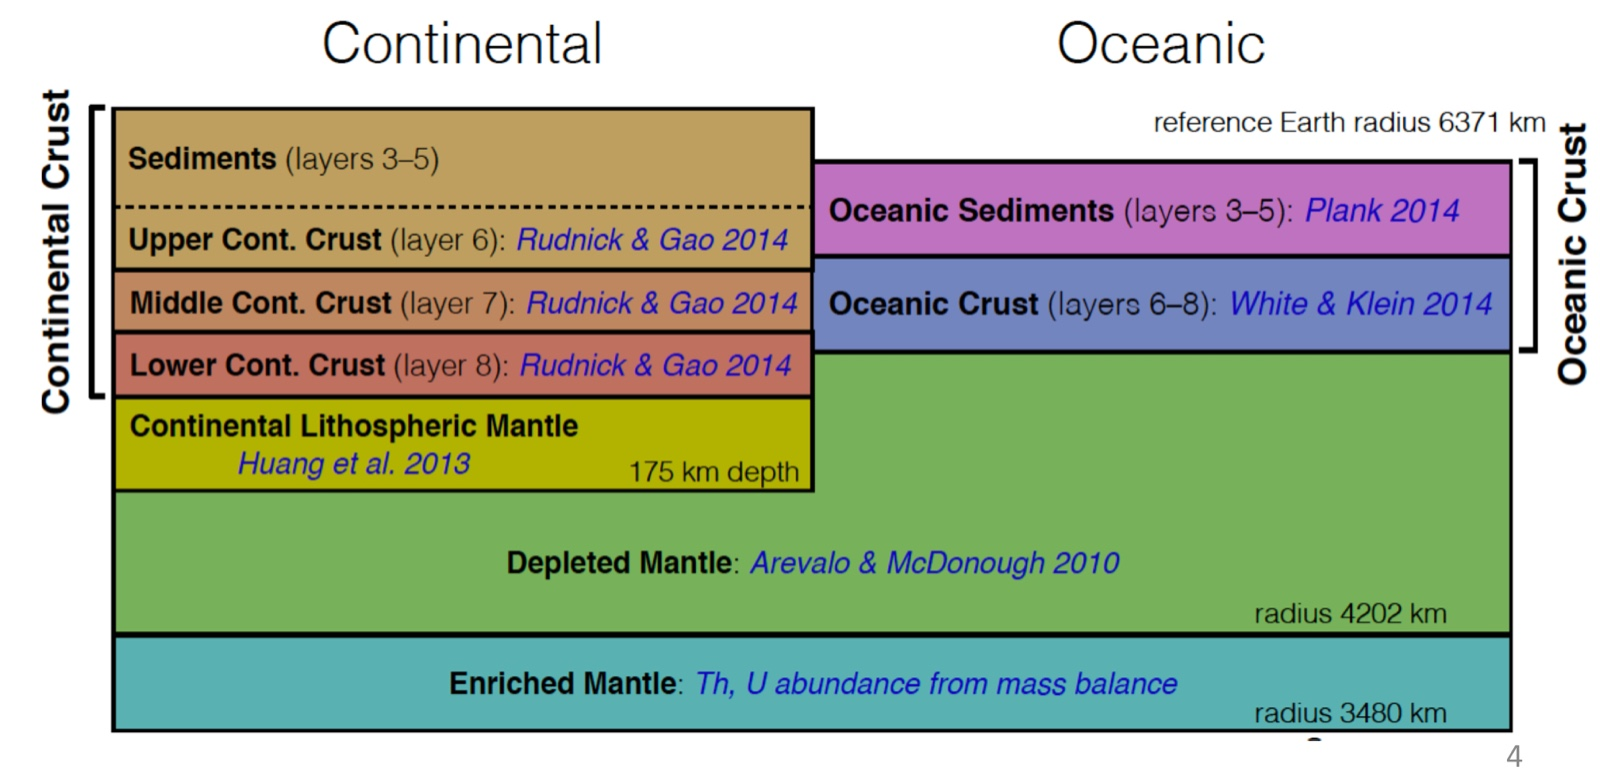

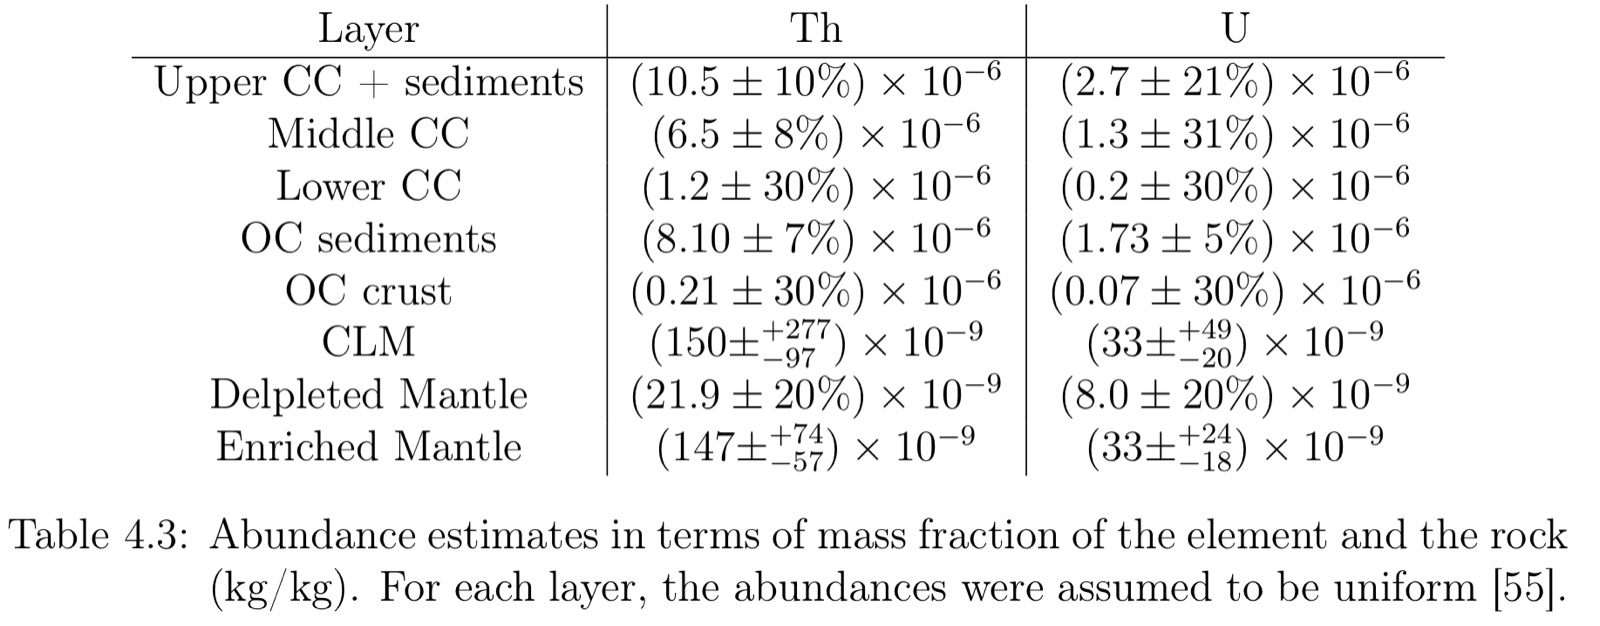

(The table with abundances is from Ingrida's thesis, and I think the colorful diagram is from docDB 5512)


For the crust abundances, we would distinguish between continental and oceanic crust in a proper model, but for now it seems like for both U and Th the average crust (sediment included) abundace for oceanic/continental are relatively similar:

$$A_{Th, crust, oceanic} = \frac{8.1 + 0.21}{2} \times 10^{-6} = 4.155 \times 10^{-6}$$
$$A_{Th, crust, continental} = \frac{10.5 + 6.5 +1.2}{3} \times 10^{-6} = 6.067 \times 10^{-6}$$
$$A_{U, crust, oceanic} = \frac{1.73 + 0.07}{2} \times 10^{-6} = 0.9 \times 10^{-6}$$
$$A_{U, crust, continental} = \frac{2.7 + 1.3 + 0.2}{3} \times 10^{-6} = 1.4 \times 10^{-6}$$

So as a very rough average, consider:

$$A_{Th, crust} = 5 \times 10^{-6}$$
$$A_{U, crust} = 1 \times 10^{-6}$$

For the mantle, the depleted mantle is thicker, but there is also CLM which will definitely be signifcant given that SNO+ is not in the ocean. The abundances for both elements in CLM are similar to those in the enriched mantle, so let's just take an equal weight average for now and maybe round it down a bit eventually:

$$A_{Th, mantle} = \frac{147 + 21.9}{2} \times 10^{-9} = 84.45 \times 10^{-9} \approx 8 \times 10^{-8}$$
$$A_{U, mantle} = \frac{8 + 33}{2} \times 10^{-9} = 20.5 \times 10^{-9} \approx 2 \times 10^{-8}$$

In [27]:
A_Th_c = 5 * (10**(-6))
A_Th_m = 8 * (10**(-8))
A_U_c = 1 * (10**(-6))
A_U_m = 2 * (10**(-8))

Let's say the Earth crust is ~20 km, and the mantle is ~2900 km (I just looked these up on google, might not be the most accurate).

Final values will be weighted by the volume of each spherical shell using the formula: $\frac{4}{3} \pi (r_{outer}^2 + r_{outer} r_{inner} + r_{inner}^2) (r_{outer} - r_{inner})$.

In [28]:
r_outer_crust = 6371
r_inner_crust = 6371 - 20
r_outer_mantle = r_inner_crust
r_inner_mantle = r_outer_mantle - 2900

def shell_volume(r_inner, r_outer):
    return (4/3)*math.pi*(r_outer**2 + r_outer*r_inner + r_inner**2)*(r_outer - r_inner)

crust_volume = shell_volume(r_inner_crust, r_outer_crust)
mantle_volume = shell_volume(r_inner_mantle, r_outer_mantle)

print("Crust volume is "+str(crust_volume))
print("Mantle volume is "+str(mantle_volume))

Crust volume is 10169298809.643768
Mantle volume is 900881093278.6835


So the average abundances in the uniform layer that we are considering (weighted by the volume of the crust and mantle) are:

$$A_{Th} = \frac{A_{Th, crust} V_{crust} + A_{Th, mantle} V_{mantle}}{V_{crust} + V_{mantle}}$$
$$A_{U} = \frac{A_{U, crust} V_{crust} + A_{U, mantle} V_{mantle}}{V_{crust} + V_{mantle}}$$

In [29]:
A_Th_mantle = (A_Th_m*mantle_volume + A_Th_c*crust_volume)/(crust_volume + mantle_volume)
A_U_mantle = (A_U_m*mantle_volume + A_U_c*crust_volume)/(crust_volume + mantle_volume)

print("Th abundance in the mantle is "+str(A_Th_mantle))
print("U abundance in the mantle is "+str(A_U_mantle))

Th abundance in the mantle is 1.349178734545746e-07
U abundance in the mantle is 3.0938926013309574e-08


Ok, so now we have a list of points that are part of the mantle, and we know the density and U/Th abundances in that region. To perform the integral, now we will need to sort out a function that calculates the survival probability. This will depend on the distance from the SNO+ detector, the energy (will write it so that it can calculate the probability for an entire array of energies), and the two oscillation parameters. The formula for the survival probability is (this is from https://www.hindawi.com/journals/ahep/2012/235686/ -- it is eq. 4.3, where $\Delta_{21}$ is written explicitly using eq. 4.2):

$$P_{ee}(E_{\nu}, |\overrightarrow{r}-\overrightarrow{r'}|) = 1 - (\cos^4 \theta_{13} \sin^2 2\theta_{12} \sin^2 ( \frac{1.27 \delta m_{21}^2 |\overrightarrow{r}-\overrightarrow{r'}|}{E_{\nu}}) + \frac{1}{2}\sin^2 2\theta_{13})$$

For the 1.27 factor to be true, $\delta m_{21}^2$ should be expressed in eV, $E_{\nu}$ in MeV and $|\overrightarrow{r}-\overrightarrow{r'}|$ in m, so we will have to use 1.27/1000 instead to express distance in km.



The position $\overrightarrow{r}$ can be hardcoded, it is the position of the SNO+ detector. Now that we're just looking at spherical shells, it doesn't matter where we put it, so set $x = y = 0$ and $z = R_{Earth} - 2 = 6369 km$. We might need to get more accurate in the future, which will be annoying to look into, but for now this is fine.

In [30]:
SNO_r = np.array([0, 0, 6369])

In [31]:
#To calculate relative positions to SNO+ given an array of points with coordinates:
'''
def calc_relative_dist(points_array):
    relative_distances = np.zeros(len(points_array))
    for i in range(len(points_array)):
        relative_distances[i] = ((points_array[0] - SNO_r[0])**2 + (points_array[1] - SNO_r[1])**2 + (points_array[2] - SNO_r[2])**2)**(0.5)
        
        return relative_distances'''

The thing above was wrong; debugged version:

In [41]:
def calc_relative_dist(points_array):
    relative_distances = np.zeros(len(points_array))
    for i in range(len(points_array)):
        # Index each point individually
        point = points_array[i]
        relative_distances[i] = np.sqrt((point[0] - SNO_r[0])**2 + (point[1] - SNO_r[1])**2 + (point[2] - SNO_r[2])**2)

    return relative_distances

The value of $\theta_{13}$ will also be fixed . The last paper measuring $\theta_{13}$ seems to be https://inspirehep.net/literature/2601288, and they measured $\sin^2 2\theta_{13} = 0.0851 ± 0.0024$ so we'll use that (without uncertainties). From https://pdgprod.lbl.gov/pdgprod/pdgLive/DataBlock.action?node=S067P13 conversion of DAYA BAY result to  $\sin^2 \theta_{13} = 0.0217$, so $\cos^2 \theta_{13} = 1 - 0.0217 = 0.9783 \implies \cos^4 \theta_{13} = 0.9571$.

Want to implement a function with these properties based on the formula above:

    Inputs: array of energies, array of points (each entry contains Cartersian coordinates for that point), theta_12, delta_m_21_squared
    Outputs: array of P_ee values, one for each combination of position and energy
    
I will format the output such that the first row are the survival probabilities corresponding to $E_1$, the first column are the survival probabilities corresponding to the first point in the array of points etc. So:

$$ P_{ee} = \begin{bmatrix}
P_{ee}(E_1, p_1) & P_{ee}(E_1, p_2) & P_{ee}(E_1, p_3) & ...\\
P_{ee}(E_2, p_1) & P_{ee}(E_2, p_2) & P_{ee}(E_2, p_3) & ...\\
...
\end{bmatrix}$$

In [42]:
test_matrix = np.zeros((2,4))
print(test_matrix)#just checking syntax for np.zeros

test_matrix[0][2] = 1
print(test_matrix)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 0. 0.]]


Writing this again so I can see it when I write the code bit:

$$P_{ee}(E_{\nu}, |\overrightarrow{r}-\overrightarrow{r'}|) = 1 - (\cos^4 \theta_{13} \sin^2 2\theta_{12} \sin^2 ( \frac{1.27 \delta m_{21}^2 |\overrightarrow{r}-\overrightarrow{r'}|}{1000 E_{\nu}}) + \frac{1}{2}\sin^2 2\theta_{13})$$

In [51]:
def P_ee(points_array, energy_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(points_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
        
    #want positions relative to sno+
    
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            P_ee[i][j] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * relative_distance_array[j] )/(1000 * energy_array[i])))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee


I used ChatGPT to check if I have any typos in my formula, and it said the formula I wrote in the code is:

$$P_{ee} = 1 - \left( \cos^4(\theta_{13}) \cdot \sin^2(2 \theta_{12}) \cdot \sin^2\left(\frac{1.27 \cdot \delta m_{21}^2 \cdot \text{relative_distance}}{1000 \cdot \text{energy}}\right) + \frac{1}{2} \cdot \sin^2(2 \theta_{13}) \right)$$

Which is great! Just what we wanted.

Now we have all the ingredients to compute the integral over positions. We will do so numerically by computing the sum:

 $$\sum_{Earth\:points} P_{ee}(E, |\overrightarrow{r}-\overrightarrow{r'}|)\frac{A(\overrightarrow{r'}) \rho(\overrightarrow{r'})}{4 \pi |\overrightarrow{r}-\overrightarrow{r'}|^2} dV$$
 
 I'm not sure if I translated the integral over $\overrightarrow{r'}$ correctly, but I think it's ok if the grid is small enough. $dV$ will be equal to the volume of one little grid cube. I think this is fine

We are summing over potisions $\overrightarrow{r'}$, so the result will actually be an array of the same size as the energies array.

We also need to sort out the association between points and abundances/densities. I think it's best if we make 3 arrays: density, Th abundance, U abundance, each with the size of the total number of earth points. For each geological model, we should make a function that loops through the points, checks what geological region the point is in, and assigns it the appropriate $\rho, A_{Th}$ and $A_U$ values to the elements at the correct index in each of the three arrays. Then, the function computing the integral will just have to read off the correct values for each point, which will be already given. 

I think this is the best way to make things a bit flexible and allow for adjusting the geological model. There are lots of loops through big arrays though so all of my code can probably be rewritten in a smarter way (this is mostly about the various nested loops I wrote).

I'll have to think of a way to make the function that assigns densities and abundances general so that you just give it a model name and it can read off the values for each region, the sets of points in each region and do all the things nicely. I'll do this later, now I'll just use the points in the mantle that I already extracted before.

In [52]:
A_Th_array = np.full(len(mantle_crust_grid), A_Th_mantle)
A_U_array = np.full(len(mantle_crust_grid), A_U_mantle)

rho_array = np.full(len(mantle_crust_grid), rho_mantle*1000) # x1000 to convert from g/cm^3 to kg/m^3

Write formula again so I can see it when I code:

$$\sum_{Earth\:points} P_{ee}(E, |\overrightarrow{r}-\overrightarrow{r'}|)\frac{A(\overrightarrow{r'}) \rho(\overrightarrow{r'})}{4 \pi |\overrightarrow{r}-\overrightarrow{r'}|^2} dV$$

I think it's also best to keep U and Th separate, I think the $\frac{dn_{\nu}}{dE}$ will depend on the element so we can get two different spectra for U/Th after all the pre-factors are sorted out. Can just add them up to get the full geonu spectrum.

In [53]:
#Thorium integral
'''
def integral_over_positions_Th(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_array, rho_array):
    
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee(points_array, energy_array, theta_12, delta_m_21_squared)
    
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            sum[j] += P_ee_array[i][j] * ((A_Th_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            
    return sum #this is an array of length = len(energy_array)
    #can identify integral for each energy by index'''

I messed out indexes in the code cell above; debugging attempt below:


In [65]:
#Thorium integral

def integral_over_positions_Th(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee(points_array, energy_array, theta_12, delta_m_21_squared)
    
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            sum[j] += P_ee_array[j][i] * ((A_Th_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            
    return sum

In [66]:
#Uranium integral

def integral_over_positions_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_U_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee(points_array, energy_array, theta_12, delta_m_21_squared)
    
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            sum[j] += P_ee_array[j][i] * ((A_U_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            
    return sum #this is an array of length = len(energy_array)
    #can identify integral for each energy by index

Now, if everything is correct and I didn't mess up any indices, we should be able to use all the ingredients we built to get the values of the integrals for U, Th separately and plot vs. energy. We only need to fix the energy array and the values for the two oscillation parameters. The threshold for IBD antinu detection is 1.8 MeV, and geoneutrinos can have energies up to 3.2 MeV, so the energies should span this range with more or less steps.

Let's say we consider 10 energy bins to begin with:

In [67]:
energy_array = np.linspace(1.8, 3.2, 10)
print(energy_array)

[1.8        1.95555556 2.11111111 2.26666667 2.42222222 2.57777778
 2.73333333 2.88888889 3.04444444 3.2       ]


For the oscillation parameters, start by using the values from Ingrida's thesis:

$$\sin^2 2 \theta_{12} = 0.861 \implies \theta_{12} = 1.04134$$
$$\Delta m_{21}^2 = 7.53 \times 10^{-5} \textrm{eV}^2$$

In [68]:
theta_12 = 1.04134
delta_m_21_squared = 7.53 * 10**(-5)

In [69]:
coordinates = np.linspace(-6371, 6371, grid_count)
grid_1d_size = coordinates[1] - coordinates[0]
print(grid_1d_size)

260.04081632653106


In [70]:
Th_integral_values = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_array, rho_array)

U_integral_values = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_U_array, rho_array)



In [72]:
print(Th_integral_values)
print(U_integral_values)

[0.91651627 0.91651629 0.9165163  0.91651631 0.91651631 0.91651632
 0.91651632 0.91651633 0.91651633 0.91651633]
[0.21017252 0.21017252 0.21017252 0.21017253 0.21017253 0.21017253
 0.21017253 0.21017253 0.21017253 0.21017253]


It makes sense for the U values to be smaller because the abundance is smaller. Maybe the difference should've been even higher. There is no significant energy dependence, which is somewhat expected - the energy range is small. Now make plots to see what these look like:

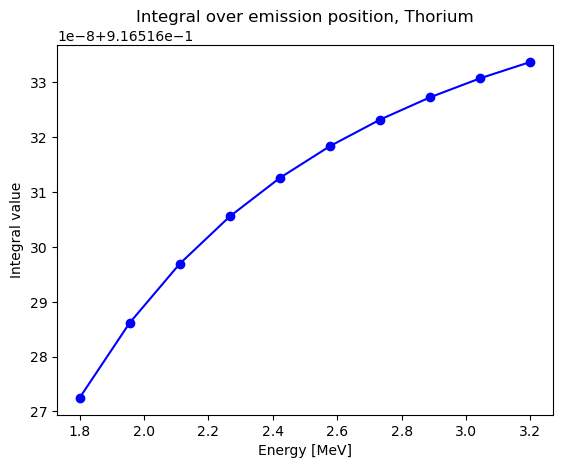

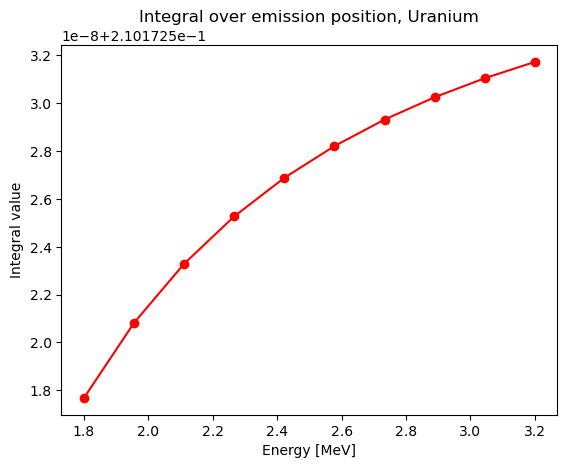

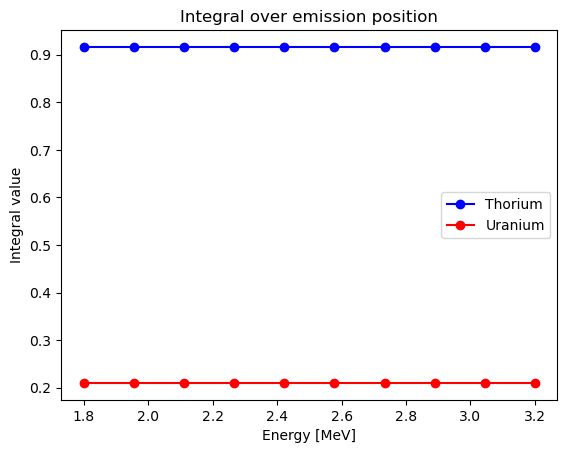

In [74]:
#Thorium
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')

plt.show()

#Uranium
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')

plt.show()

#Both together
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r', label='Uranium')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')

plt.legend()

plt.show()

Sooooo the integral is just constant over energy, pretty much. Cool. Now we have to weight them by the pre-factors and the IBD cross section to get the expected counts for each energy bin.